#Terms of Use
By using this colab to download the brain dataset (i.e., data including fMRI, images, labels), you agree to the following terms:

1. You will use the Datasets only for non-commercial research and educational purposes.
2. You will NOT distribute the Datasets or any parts thereof.
3. Massachusetts Institute of Technology make no representations or warranties regarding the datasets, including but not limited to warranties of non-infringement or fitness for a particular purpose.
4. You accept full responsibility for your use of the datasets and shall defend and indemnify Massachusetts Institute of Technology and International Business Machines Corporation, including its employees, officers and agents, against any and all claims arising from your use of the datasets, including but not limited to your use of any copyrighted images that you may create from the datasets.
5. You will treat people appearing in this data with respect and dignity.
6. This data comes with no warranty or guarantee of any kind, and you accept full liability.

In [ ]:
import numpy as np

In [ ]:
arr_1= np.array([[1,2,7],[3,4,8]])
arr_2=np.array([[1,2],[3,9],[4,16]])
c=np.dot(arr_1,arr_2)
print(c)

[[ 35 132]
 [ 47 170]]


# Predicting fMRI responses from Algonauts2021 dataset

**Goal:** Here we show how to prepare submission for Algonauts 2021 challenge using AlexNet as an example.

This notebook is organized as follows:

1. Loading fMRI responses to videos and visualizing in glass brain using nilearn.
2. Feedforward the videos from stimulus set to the AlexNet model pretrained on Imagenet dataset to extract AlexNet activations from different layers and apply PCA for dimensionality reduction.
3.   Train a linear regression to predict fMRI responses from AlexNet activations.
4.   Evaluate the model by comparing the correlation between predicted and recorded fMRI responses on validation set. 
5. Generate predicted fMRI responses to test videos for all subjects all ROIs
6. Preparing submission files for codalab



In [ ]:
#@title Installations
%%capture

!pip install nilearn
!pip install decord

In [ ]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Get the dropbox link to download dataset by filling this [google form](https://forms.gle/qq9uqqu6SwN8ytxQ9). 

In [ ]:
#@title Enter the download link and run the cell
download_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0' #@param {type:"string"}
os.environ["download_link"] = download_link
!echo $download_link 
!wget -O participants_data.zip -c $download_link  
!unzip participants_data.zip
!wget -O example.nii -c https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii
!wget -c https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/class_names_ImageNet.txt

https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0
--2021-08-17 17:12:21--  https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/agxyxntrbwko7t1/participants_data.zip [following]
--2021-08-17 17:12:21--  https://www.dropbox.com/s/raw/agxyxntrbwko7t1/participants_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0365ad9ee184c8fa34007d8a2b.dl.dropboxusercontent.com/cd/0/inline/BUa7DF7_q9gseQd97S5giVb-iTTo-oa1zYYbHo1Io0NH9x8SO9Rsiuj4xTIM15r2mfvCgKMonxweeGhwaKFXasRRMadjZVyYFu4Q9TlgzojqBw5sNyjLL2i1yli_6UkxRQ1juTO9C1-g0hOMybVO6D-r/file# [following]
--2021-08-17 17:12:22--  https://uc0365ad9ee184c8fa34007d8a2b.dl.dropboxusercontent.com/c

#fMRI Data

The Algonauts dataset provides human brain responses to a set of 1,102 3-s long video clips of everyday events. The brain responses are measured with functional magnetic resonance imaging (fMRI). fMRI is a widely used brain imaging technique with high spatial resolution that measures blood flow changes associated with neural responses.

The training set consists of 1,000 video clips and the associated brain responses. The brain responses are provided here in two tracks corresponding to two independent tracks in the Algonauts challenge. 

In the **full track**, brain responses provided are from selected voxels across the whole brain showing reliable responses to videos. The figure below shows the reliability values of different voxels in the brain.
 

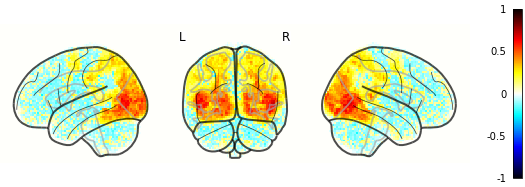

In the **mini track**, brain responses provided are from a set of specific regions of interest (ROIs) known to play a key role in visual perception. These ROIs start in early and mid-level visual cortex (V1, V2, V3, and V4) and extend into higher-level cortex that responds preferentially to all objects or particular categories (Body- EBA; Face - FFA, STS; Object - LOC; Scene - PPA). In the figure below we show the masks of the above mentioned ROIs for an example subject.


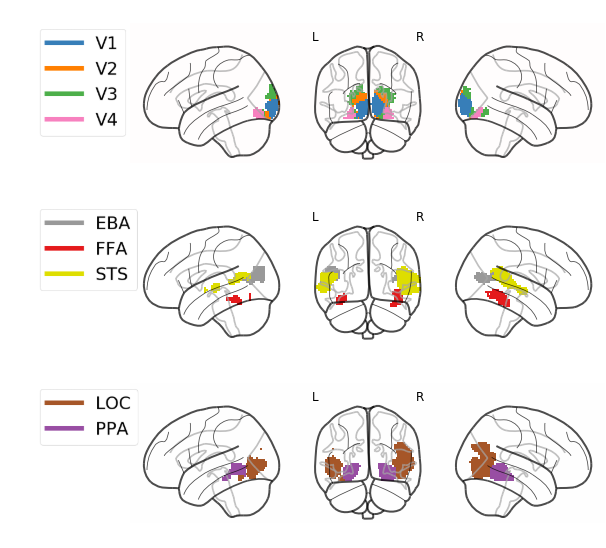

#Loading fMRI data
The trainig dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set. 

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. V1.pkl) that contains a num_videos x num_repetitions x num_voxels matrix. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. WB.pkl) that contains a num_videos x num_repetitions x num_voxels matrix.

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [ ]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
  fmri_dir = './participants_data_v2021' 
  track = "full_track"
  results_dir = '/content/'
  track_dir = os.path.join(fmri_dir, track) 
  sub_fmri_dir = os.path.join(track_dir, sub)
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB") 
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
  brain_mask = '/content/example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

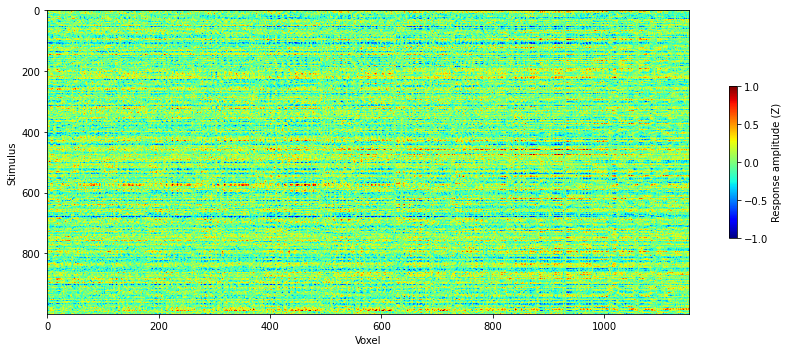

In [ ]:
#@title Loading fMRI data and inspecting dimensions
sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

ROI = 'LOC'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

######## fMRI data loader wrapper code ###################################
fmri_dir = '/content/participants_data_v2021' 
if ROI == "WB":
    track = "full_track"
else:
    track = "mini_track"
results_dir = '/content/'
track_dir = os.path.join(fmri_dir, track) 
sub_fmri_dir = os.path.join(track_dir, sub)
if track == "full_track":
    fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
else:
    fmri_train_all = get_fmri(sub_fmri_dir,ROI)

######## fMRI data loader wrapper code ###################################


f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The above matrix shows each individual voxel's (columns) response to 1000 videos (rows). To find out more details about how the fMRI data were preprocessed please click [here](http://algonauts.csail.mit.edu/brainmappingandanalysis.html). 

Visualize a given video (with id from 0-999) and its corresponding brain activity

In [ ]:
#@title Visualize video
vid_id = 267 #@param {type: "integer"}
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'

########### Video display code #################################################
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()

#visualize_brain_activity(video_dir,fmri_train_all,vid_id)
from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_list[vid_id],'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)
########### Video display code #################################################

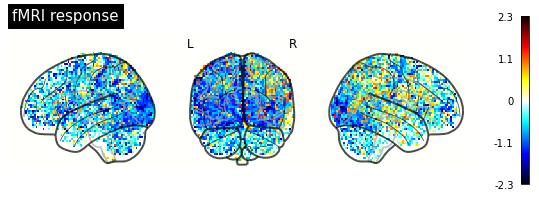

In [ ]:
#@title Visualize corresponding brain response
visualize_activity(vid_id,sub)

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos. 

# Vision Model definition (ResNet)

Run the next cell to define the architecture of the model using pytorch.

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        layer1 = self.conv1(x)
        layer2 = self.bn1(layer1)
        layer3 = self.relu(layer2)
        layer4 = self.maxpool(layer3)

        layer5 = self.layer1(layer4)
        layer6 = self.layer2(layer5)
        layer7 = self.layer3(layer6)
        layer8 = self.layer4(layer7)

        layer9 = self.avgpool(layer8)
        layer10 = torch.flatten(layer9, 1)
        layer11= self.fc(layer10)

        return layer11

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = True, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)
mod = resnet50()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#Feature Extraction
Run the next cell to extract Alexnet activations on the videos from the stimulus set. We will use these later to train a regression for predicting fMRI responses. 

In [ ]:
#@title Functions for loading videos and extracting features
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)



def print_alexnet_predictions(output):
    with open('class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]

    # sort the probability vector in descending order
    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0
    # obtain the first 5 classes (with the highest probability) the input belongs to
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    for i in range(5):
        print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
    

def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images,num_frames

def get_activations_and_save(model, video_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    video_list : list
        the list contains path to all videos.
    activations_dir : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    for video_file in tqdm(video_list):
        vid,num_frames = sample_video_from_mp4(video_file)
        video_file_name = os.path.split(video_file)[-1].split(".")[0]
        activations = []
        for frame,img in enumerate(vid):
            input_img = V(resize_normalize(img).unsqueeze(0))
            if torch.cuda.is_available():
                input_img=input_img.cuda()
            x = model.forward(input_img)
            for i,feat in enumerate(x):
                if frame==0:
                    if i==1:
                        print("\nTop-5 Predictions for the video id: ", video_file_name)
                        print_alexnet_predictions(feat)
                    activations.append(feat.data.cpu().numpy().ravel())
                else:
                    activations[i] =  activations[i] + feat.data.cpu().numpy().ravel()
        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, video_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            avg_layer_activation = activations[layer]/float(num_frames)
            np.save(save_path,avg_layer_activation)

def do_PCA_and_save(activations_dir, save_dir):
    """This function preprocesses Neural Network features using PCA and save the results
    in  a specified directory
.
    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.
    """

    layers = ['layer_11']
    n_components = 100
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for layer in tqdm(layers):
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        x_train = x[:1000,:]
        x_test = x[1000:,:]

        start_time = time.time()
        x_test = StandardScaler().fit_transform(x_test)
        x_train = StandardScaler().fit_transform(x_train)
        ipca = PCA(n_components=n_components,random_state=seed)
        ipca.fit(x_train)

        x_train = ipca.transform(x_train)
        x_test = ipca.transform(x_test)
        train_save_path = os.path.join(save_dir,"train_"+layer)
        test_save_path = os.path.join(save_dir,"test_"+layer)
        np.save(train_save_path,x_train)
        np.save(test_save_path,x_test)

In [ ]:


video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
print('Total Number of Videos: ', len(video_list))
save_dir = "/content/activations_alexnet"
# load Alexnet
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
model = mod
# get and save activations

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, video_list, activations_dir)

Total Number of Videos:  1102
-------------Saving activations ----------------------------


 35%|███▌      | 389/1102 [22:01<40:22,  3.40s/it]


KeyboardInterrupt: ignored

In [ ]:
# preprocessing using PCA and save
pca_dir = os.path.join(save_dir, 'pca_100')
print("-------------performing  PCA----------------------------")
do_PCA_and_save(activations_dir, pca_dir)

-------------performing  PCA----------------------------


  0%|          | 0/11 [00:00<?, ?it/s]

# Voxel Wise Encoding

The approach has three steps: 

1. Features of a computer vision model to videos are extracted (Fig. 1A). This changes the format of the data (from pixels to model features) and typically reduces the dimensionality of the data. The features of a given model are interpreted as a potential hypothesis about the features that a given brain area might be using to represent the stimulus. 
2. Features of the computational model are linearly mapped onto each voxel's responses (Fig. 1B) using the training set provided. This step is necessary as there is not necessarily a one-to-one mapping between voxels and model features. Instead, each voxel's response is hypothesized to correspond to a weighted combination of activations of multiple features of the model. 
3. The estimated mapping from the training dataset is applied on the model features corresponding to videos in the test set to predict synthetic brain data (Fig. 1C). The predicted synthetic brain data is then compared against the ground-truth left out brain data in the testing set. 



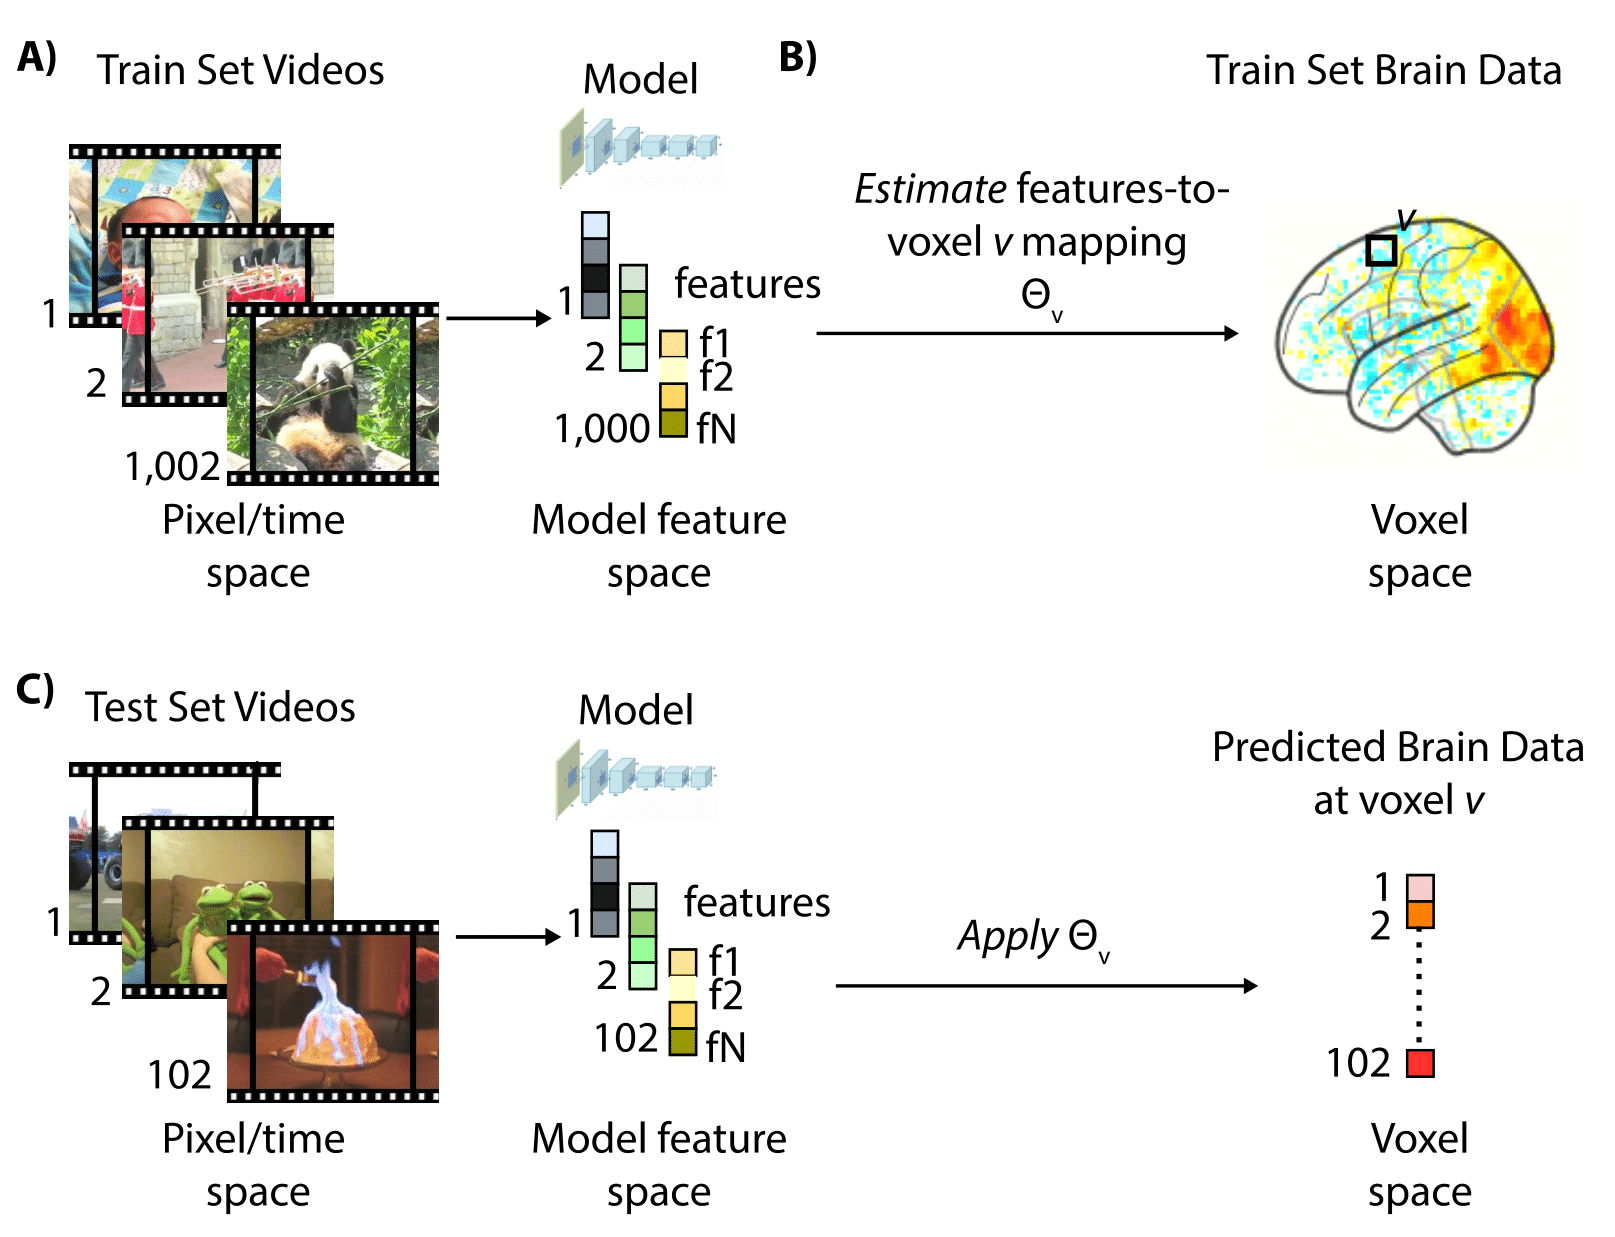

**Figure 1**: **A)** First, given the training set videos, the features of a computational model are extracted. **B)** A mapping between model features and brain voxels is estimated from the Training Set videos. **C)** A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.

## Evaluation

To determine how well a model predicts brain responses we compare synthetic brain data (i.e. those predicted from your model to the left out video clips) to the empirically measured brain responses. The comparison is carried out using Pearson's correlation, comparing for each voxel the 100-dimensional vector formed by the activations for the 100 validation set video clips.

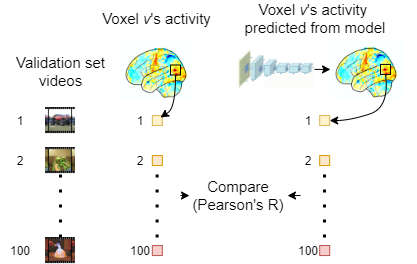

In [ ]:
#@title Utility functions for regression
def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

class OLS_pytorch(object):
    def __init__(self,use_gpu=False):
        self.coefficients = []
        self.use_gpu = use_gpu
        self.X = None
        self.y = None

    def fit(self,X,y):
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)

        X =  self._concatenate_ones(X)

        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()
        if self.use_gpu:
            X = X.cuda()
            y = y.cuda()
        XtX = torch.matmul(X.t(),X)
        Xty = torch.matmul(X.t(),y.unsqueeze(2))
        XtX = XtX.unsqueeze(0)
        XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
        betas_cholesky, _ = torch.solve(Xty, XtX)

        self.coefficients = betas_cholesky

    def predict(self, entry):
        if len(entry.shape) == 1:
            entry = self._reshape_x(entry)
        entry =  self._concatenate_ones(entry)
        entry = torch.from_numpy(entry).float()
        if self.use_gpu:
            entry = entry.cuda()
        prediction = torch.matmul(entry,self.coefficients)
        prediction = prediction.cpu().numpy()
        prediction = np.squeeze(prediction).T
        return prediction

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

def predict_fmri_fast(train_activations, test_activations, train_fmri,use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.
    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions #train_vids x  #voxels
        containing fMRI responses to train videos
    use_gpu : bool
        Description of parameter `use_gpu`.
    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions #test_vids x  #voxels
        containing predicted fMRI responses to test videos .
    """

    reg = OLS_pytorch(use_gpu)
    reg.fit(train_activations,train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    return fmri_pred_test

            

In [ ]:
def perform_encoding(activation_dir, fmri_dir,results_dir, sub, layer, ROI = 'WB', mode = 'val', visualize_results = True\
                     , batch_size=1000):
  if torch.cuda.is_available():
      use_gpu = True
  else:
      use_gpu = False

  ###### Load activations ##############
  activations_dir = '/content/activations_alexnet'
  pca_dir = os.path.join(activations_dir,'pca_100')
  train_activations,test_activations = get_activations(pca_dir, layer)
  ######################################

  ##### Load fMRI data #################
  if ROI == "WB":
      track = "full_track"
  else:
      track = "mini_track"
  fmri_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(fmri_dir, sub)
  if track == "full_track":
      fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
  else:
      fmri_train_all = get_fmri(sub_fmri_dir,ROI)
  num_voxels = fmri_train_all.shape[1]
  ######################################


  #### Creating data splits ###############
  if mode == 'val':
      # Here as an example we use first 900 videos as training and rest of the videos as validation
      test_activations = train_activations[900:,:]
      train_activations = train_activations[:900,:]
      fmri_train = fmri_train_all[:900,:]
      fmri_test = fmri_train_all[900:,:]
      pred_fmri = np.zeros_like(fmri_test)
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
  else:
      fmri_train = fmri_train_all
      num_test_videos = 102
      pred_fmri = np.zeros((num_test_videos,num_voxels))
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
  ######################################

  ######## Performing regression ################
  iter = 0
  
  while iter < num_voxels-batch_size:
      pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
      iter = iter+batch_size
  pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
  if mode == 'val':
    score = vectorized_correlation(fmri_test,pred_fmri)
    print("----------------------------------------------------------------------------")
    print("Mean correlation for ROI : ",ROI, "in ",sub," using ",layer, " is :", round(score.mean(), 6))
    ################################################
    
    nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
    ######## Result visualization ################
    if track == "full_track" and visualize_results:
        visual_mask_3D = np.zeros((78,93,71))
        visual_mask_3D[voxel_mask==1]= score
        brain_mask = '/content/example.nii'
        saveasnii(brain_mask,nii_save_path,visual_mask_3D)
        plotting.plot_glass_brain(nii_save_path,plot_abs=False,
                          title='Correlation for ' + sub+ ' and ' + layer,
                          display_mode='lyr',colorbar=True,vmin=-1,vmax=1)

    ################################################

  np.save(pred_fmri_save_path, pred_fmri)


In [ ]:
#@title Perform and evaluate encoding on validation set
sub = 'sub01'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

ROI = 'EBA'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

layer = 'layer_5' #@param ["layer_1","layer_2","layer_3","layer_4","layer_5"]

fmri_dir = '/content/participants_data_v2021'
prediction_dir = '/content/prediction'

if ROI == "WB":
    track = "full_track"
else:
    track = "mini_track"
model = 'resnet18'
results_dir = os.path.join(prediction_dir,model, layer,\
                           track, sub)
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
perform_encoding(activations_dir, fmri_dir,\
                                 results_dir, sub, layer, ROI=ROI)
  

----------------------------------------------------------------------------
Mean correlation for ROI :  EBA in  sub01  using  layer_5  is : 0.113731


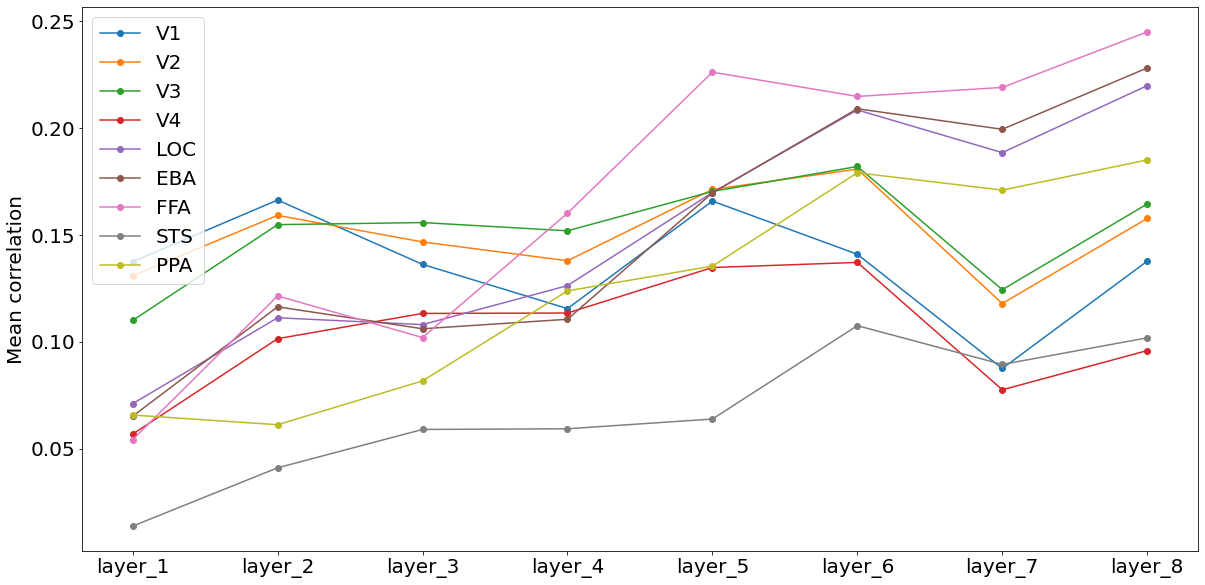

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x= ['layer_1','layer_2','layer_3', 'layer_4','layer_5', 'layer_6', 'layer_7', 'layer_8']
v1= [0.137534,0.166409,0.136286, 0.115591,0.165914, 0.14102, 0.087553, 0.137788 ]
v2= [0.130939, 0.159219, 0.146786,0.137981, 0.171356, 0.180893, 0.117974, 0.157783 ]
v3= [0.11006, 0.15489,0.155859, 0.15201, 0.170426,0.182105, 0.124452,0.164554   ]
v4= [0.056831,0.10151, 0.113329,0.113519, 0.134812, 0.137205, 0.077578,0.095936  ]
loc= [0.071084, 0.111297,0.108088, 0.126341, 0.169899, 0.208582, 0.188603,0.219937  ]
eba= [0.065217,0.11643,0.106157, 0.110595, 0.169757, 0.209148,  0.199525, 0.228225 ]
ffa= [0.054265, 0.121548, 0.10202, 0.160222,0.226247, 0.214897 , 0.219123, 0.245102 ]
sts= [0.013783,0.04107,0.059021,  0.059328,0.063891 , 0.107604, 0.089455, 0.101907 ]
ppa= [0.065762, 0.061241, 0.081747,0.123888,  0.13547, 0.179174, 0.171044,0.18518 ]
plt.figure(figsize=(20,10))
plt.plot(x,v1,marker='o')
plt.plot(x, v2,marker='o')
plt.plot(x,v3,marker='o')
plt.plot(x,v4,marker='o')
plt.plot(x,loc,marker='o')
plt.plot(x,eba,marker='o')
plt.plot(x, ffa,marker='o')
plt.plot(x,sts,marker='o')
plt.plot(x,ppa,marker='o')
plt.ylabel('Mean correlation')
plt.rcParams.update({'font.size': 20})
plt.legend(["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"])
#plt.savefig('sample_2.png')


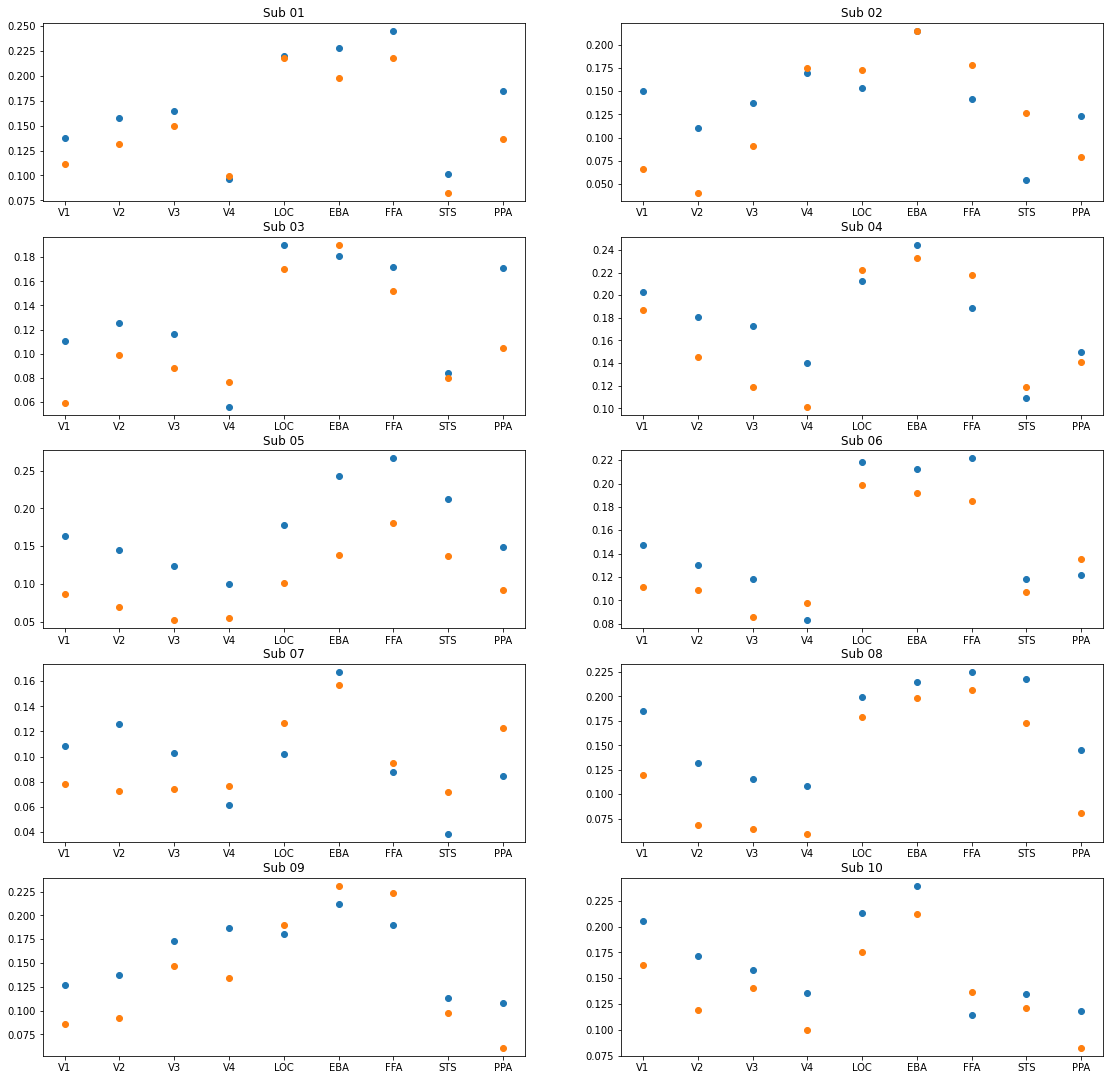

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sub1_resnet = [0.111592,0.131121,0.150027,0.099516,0.217756,0.197476,0.217829,0.082385,0.13613]
sub2_resnet = [0.066061,0.040291,0.091083,0.174558,0.172501,0.214788,0.178473,0.125997,0.079056]
sub3_resnet = [0.059647,0.099277,0.088434,0.076317,0.170386,0.189803,0.151905,0.07963,0.104851]
sub4_resnet = [0.186621,0.14522,0.119224,0.101466,0.222372,0.233242,0.217464,0.11901,0.140596]
sub5_resnet = [0.086162,0.069088,0.051884,0.054627,0.101,0.138508,0.180393,0.137494,0.092353]
sub6_resnet = [0.111799,0.108674,0.085706,0.097373,0.198543,0.191651,0.184947,0.107064,0.13524]
sub7_resnet = [0.078464,0.072556,0.073736,0.076866,0.126967,0.15728,0.094813,0.071385,0.122574]
sub8_resnet = [0.119256,0.068001,0.064234,0.059157,0.178826,0.198563,0.207129,0.173351,0.081095]
sub9_resnet = [0.086323,0.092614,0.147346,0.134124,0.189878,0.231116,0.223778,0.096979,0.061042]
sub10_resnet = [0.162333,0.118668,0.140703,0.099814,0.175632,0.212572,0.13625,0.121462,0.082596]
x= ["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
sub1 = [0.137788, 0.157783, 0.164554, 0.095936, 0.219937, 0.228225,0.245102, 0.101907,0.18518 ]
sub2= [0.150409, 0.110278,0.137667,0.169814, 0.153522,  0.21459, 0.141822,0.054564, 0.123408  ]
sub3= [0.110355,0.125778,0.116343,0.056333,0.190214,0.180689,0.172113,0.084475,0.170712]
sub4= [0.202481,0.181161,0.173077,0.140259,0.212679,0.244629,0.188815,0.108998,0.149983]
sub5= [0.16307,0.144521,0.123846,0.099787,0.17794,0.243172,0.266094,0.213078,0.148708]
sub6= [0.147522,0.130245,0.11867,0.082866,0.218399,0.212808,0.221477,0.118313,0.12191]
sub7= [0.108271,0.126058,0.102565,0.061004,0.101938,0.167192,0.087433,0.038288,0.084499]
sub8= [0.184747,0.132264,0.115502,0.108705,0.199199,0.21498,0.22495,0.21817,0.145376]
sub9= [0.126443,0.137713,0.173295,0.18706,0.180901,0.212286,0.189755,0.112811,0.107839]
sub10= [0.205672,0.171873,0.157666,0.135384,0.213444,0.239428,0.114203,0.135012,0.118021]
fig, axs = plt.subplots(5, 2, figsize=(19, 19))
axs[0, 0].scatter(x, sub1, )
axs[0, 0].scatter(x, sub1_resnet)
axs[0,0].title.set_text('Sub 01')

axs[0, 1].scatter(x, sub2)
axs[0, 1].scatter(x, sub2_resnet)
axs[0,1].title.set_text('Sub 02')

axs[1, 0].scatter(x, sub3)
axs[1, 0].scatter(x, sub3_resnet)
axs[1,0].title.set_text('Sub 03')

axs[1, 1].scatter(x, sub4)
axs[1, 1].scatter(x, sub4_resnet)
axs[1,1].title.set_text('Sub 04')

axs[2, 0].scatter(x, sub5)
axs[2, 0].scatter(x, sub5_resnet)
axs[2,0].title.set_text('Sub 05')

axs[2, 1].scatter(x, sub6)
axs[2, 1].scatter(x, sub6_resnet)
axs[2,1].title.set_text('Sub 06')

axs[3, 0].scatter(x, sub7)
axs[3, 0].scatter(x, sub7_resnet)
axs[3,0].title.set_text('Sub 07')

axs[3, 1].scatter(x, sub8)
axs[3, 1].scatter(x, sub8_resnet)
axs[3,1].title.set_text('Sub 08')

axs[4, 0].scatter(x, sub9)
axs[4, 0].scatter(x, sub9_resnet)
axs[4,0].title.set_text('Sub 09')

axs[4, 1].scatter(x, sub10)
axs[4, 1].scatter(x, sub10_resnet)
axs[4,1].title.set_text('Sub 10')
plt.savefig('sample_3.png')


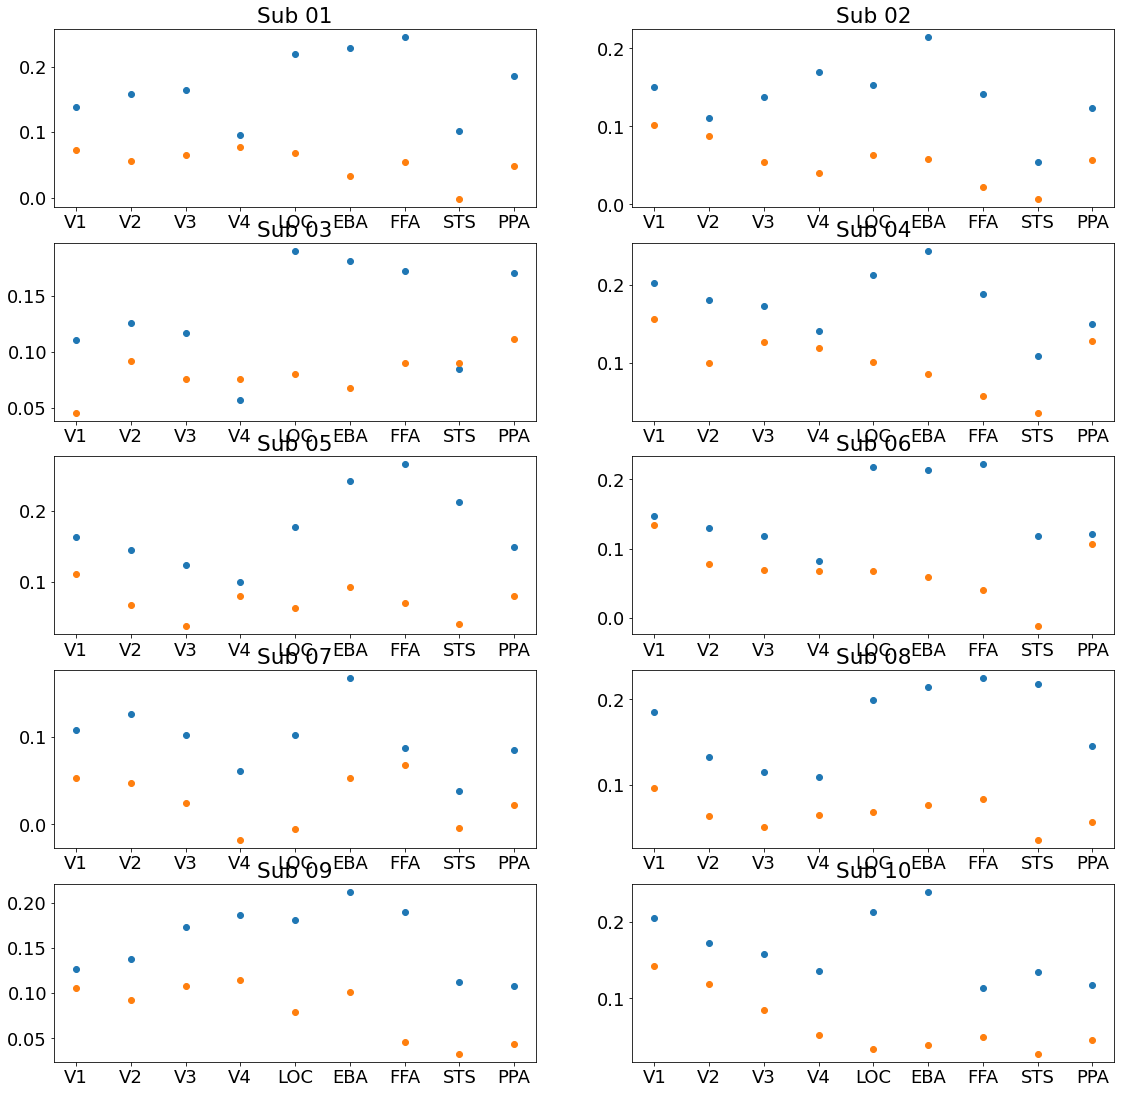

In [ ]:
x= ["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
sub1_resnet_wide = [0.073146,0.05638,0.06581,0.077722,0.067667,0.033503,0.053927,-0.001969,0.047849]
sub2_resnet_wide = [0.102291,0.08745,0.054215,0.039677,0.062877,0.057675,0.021711,0.006884,0.056328]
sub3_resnet_wide = [0.04544,0.091973,0.075927,0.07559,0.079917,0.067703,0.089605,0.089983,0.111229]
sub4_resnet_wide = [0.156796,0.099691,0.127206,0.119361,0.100752,0.085012,0.056237,0.03526,0.127688]
sub5_resnet_wide = [0.111518,0.066796,0.036711,0.079291,0.062961,0.092047,0.069284,0.040419,0.080337]
sub6_resnet_wide = [0.134198,0.078008,0.06953,0.068213,0.068182,0.058644,0.041106,-0.011815,0.106287]
sub7_resnet_wide = [0.053486,0.046715,0.023924,-0.017948,-0.005136,0.053475,0.067611,-0.004583,0.021778]
sub8_resnet_wide = [0.096176,0.063854,0.05066,0.064155,0.068191,0.076526,0.083218,0.035247,0.056417]
sub9_resnet_wide = [0.106147,0.092837,0.107877,0.114892,0.078878,0.100877,0.046375,0.032939,0.043937]
sub10_resnet_wide = [0.142338,0.119472,0.084942,0.051754,0.033357,0.038593,0.049054,0.02781,0.045244]
sub1 = [0.137788, 0.157783, 0.164554, 0.095936, 0.219937, 0.228225,0.245102, 0.101907,0.18518 ]
sub2= [0.150409, 0.110278,0.137667,0.169814, 0.153522,  0.21459, 0.141822,0.054564, 0.123408  ]
sub3= [0.110355,0.125778,0.116343,0.056333,0.190214,0.180689,0.172113,0.084475,0.170712]
sub4= [0.202481,0.181161,0.173077,0.140259,0.212679,0.244629,0.188815,0.108998,0.149983]
sub5= [0.16307,0.144521,0.123846,0.099787,0.17794,0.243172,0.266094,0.213078,0.148708]
sub6= [0.147522,0.130245,0.11867,0.082866,0.218399,0.212808,0.221477,0.118313,0.12191]
sub7= [0.108271,0.126058,0.102565,0.061004,0.101938,0.167192,0.087433,0.038288,0.084499]
sub8= [0.184747,0.132264,0.115502,0.108705,0.199199,0.21498,0.22495,0.21817,0.145376]
sub9= [0.126443,0.137713,0.173295,0.18706,0.180901,0.212286,0.189755,0.112811,0.107839]
sub10= [0.205672,0.171873,0.157666,0.135384,0.213444,0.239428,0.114203,0.135012,0.118021]

fig, axs = plt.subplots(5, 2, figsize=(19,19))
axs[0, 0].scatter(x, sub1)
axs[0, 0].scatter(x, sub1_resnet_wide)
axs[0,0].title.set_text('Sub 01')

axs[0, 1].scatter(x, sub2)
axs[0, 1].scatter(x, sub2_resnet_wide)
axs[0,1].title.set_text('Sub 02')

axs[1, 0].scatter(x, sub3)
axs[1, 0].scatter(x, sub3_resnet_wide)
axs[1,0].title.set_text('Sub 03')

axs[1, 1].scatter(x, sub4)
axs[1, 1].scatter(x, sub4_resnet_wide)
axs[1,1].title.set_text('Sub 04')

axs[2, 0].scatter(x, sub5)
axs[2, 0].scatter(x, sub5_resnet_wide)
axs[2,0].title.set_text('Sub 05')

axs[2, 1].scatter(x, sub6)
axs[2, 1].scatter(x, sub6_resnet_wide)
axs[2,1].title.set_text('Sub 06')

axs[3, 0].scatter(x, sub7)
axs[3, 0].scatter(x, sub7_resnet_wide)
axs[3,0].title.set_text('Sub 07')

axs[3, 1].scatter(x, sub8)
axs[3, 1].scatter(x, sub8_resnet_wide)
axs[3,1].title.set_text('Sub 08')

axs[4, 0].scatter(x, sub9)
axs[4, 0].scatter(x, sub9_resnet_wide)
axs[4,0].title.set_text('Sub 09')

axs[4, 1].scatter(x, sub10)
axs[4, 1].scatter(x, sub10_resnet_wide)
axs[4,1].title.set_text('Sub 10')
plt.savefig('sample_4.png')


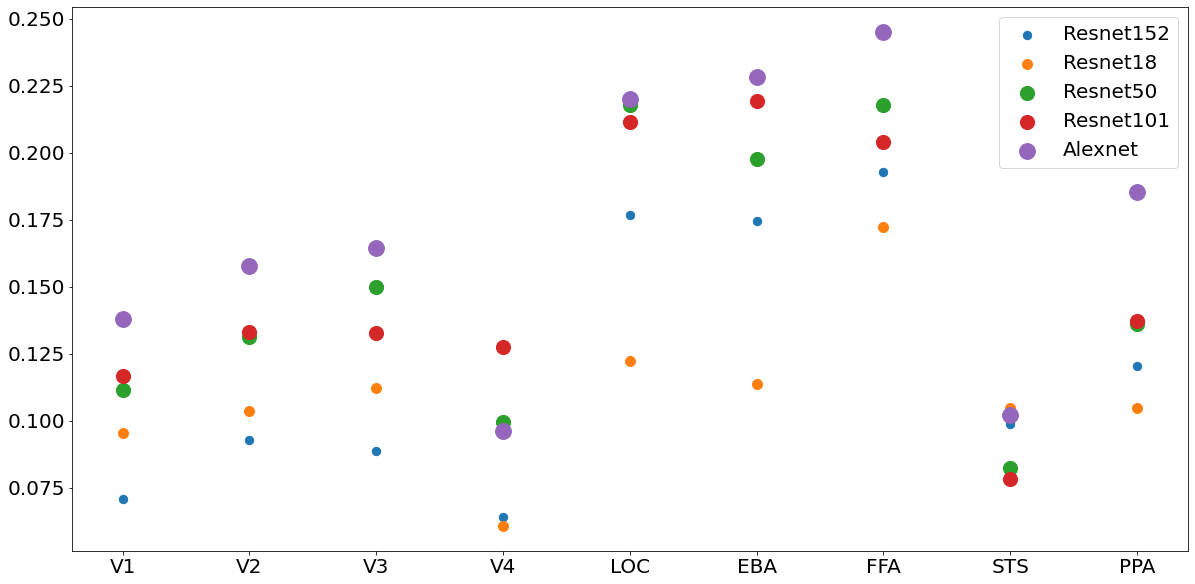

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

roi=np.array(["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"])
resnet18=np.array([0.095532,0.103577,0.112309,0.060622,0.122113,0.113731,0.172133,0.104622,0.104622])
resnet50=np.array([0.111592,0.131121,0.150027,0.099516,0.217756,0.197476,0.217829,0.082385,0.13613])
resnet101=np.array([0.116552,0.132943,0.132666,0.127624,0.211326,0.219247,0.204118,0.078125,0.137091])
resnet152=np.array([0.070702,0.092815,0.088778,0.063988,0.176723,0.174613,0.192778,0.098551,0.12025])
alexnet=np.array([0.137788,0.157783,0.164554,0.095936,0.219937,0.228225,0.245102,0.101907,0.18518])
plt.figure(figsize=(20,10))
plt.scatter(roi,resnet152,s=70)
plt.scatter(roi,resnet18,s=100)
plt.scatter(roi,resnet50,s=200)
plt.scatter(roi,resnet101,s=200)
plt.scatter(roi,alexnet,s=250)

plt.legend(['Resnet152','Resnet18','Resnet50','Resnet101','Alexnet'])
#plt.savefig('sample_1.png')
plt.show()


In [ ]:
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layer = 'layer_1'
for sub in subs:
  for ROI in ROIs:
    if ROI == "WB":
        track = "full_track"
    else:
        track = "mini_track"
        perform_encoding(activations_dir, fmri_dir,\
                     results_dir, sub, layer,\
                     ROI=ROI,mode='val')

If you use the default parameters (sub04, EBA, layer_5) you should obtain a correlation of 0.219 between predicted and recorded fMRI responses on validation videos.

# Predict fMRI responses to test videos for all subjects all ROIs
Run the cell below to save predicted fMRI responses to test videos for all subjects and ROIs.

In [ ]:
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layer = 'layer_5'
model = 'alexnet'
for sub in subs:
  for ROI in ROIs:
    if ROI == "WB":
        track = "full_track"
    else:
        track = "mini_track"
    results_dir = os.path.join(prediction_dir,model, layer,\
                           track, sub)
    if not os.path.exists(results_dir):
      os.makedirs(results_dir)
    print ("Starting ROI: ", ROI, "sub: ",sub)
    perform_encoding(activations_dir, fmri_dir,\
                     results_dir, sub, layer,\
                     ROI=ROI,mode='test')
    print ("Completed ROI: ", ROI, "sub: ",sub)
    print("----------------------------------------------------------------------------")

Starting ROI:  WB sub:  sub01
Completed ROI:  WB sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub01
Completed ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub01
Completed ROI:  V2 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub01
Completed ROI:  V3 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub01
Completed ROI:  V4 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub01
Completed ROI:  LOC sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub01
Completed ROI:  EBA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub01

#Prepare submission files

Now, we will prepare the zipfiles for submission to codalab. After running the two cells below you will see a Pickle and a zip file (containing the Pickle file) for the corresponding track in the colab file directory. 

Submit the mini_track results [here](https://competitions.codalab.org/competitions/30930#participate-submit_results) and full_track results [here](https://competitions.codalab.org/competitions/30937#participate-submit_results)

In [ ]:
def prepare_results(submission_dir, track):
    if track == 'full_track':
        ROIs = ['WB']
    else:
        ROIs = ['LOC','FFA','STS','EBA','PPA','V1','V2','V3','V4']

    num_subs = 10
    subs=[]
    for s in range(num_subs):
        subs.append('sub'+str(s+1).zfill(2))

    results = {}
    for ROI in ROIs:
        ROI_results = {}
        for sub in subs:
            ROI_result_file = os.path.join(submission_dir,track,sub,ROI+"_test.npy")
            if not os.path.exists(ROI_result_file):
                print("---------Warning : submission not ready ----------")
                print("Result not found for ",sub, " and ROI: ",ROI)
                print("Result file path: ", ROI_result_file)
                print("Please check if the directory is correct or generate predicted data for ROI: ",ROI , " in subject: ", sub)
                return
            ROI_result = np.load(ROI_result_file)
            ROI_results[sub] = ROI_result
        results[ROI] = ROI_results

    save_dict(results,track+".pkl")
    zipped_results = zipfile.ZipFile(track+".zip", 'w')
    zipped_results.write(track+".pkl")
    zipped_results.close()

In [ ]:
import zipfile
submission_dir = '/content/prediction/alexnet/layer_5'
prepare_results(submission_dir, 'full_track')
prepare_results(submission_dir, 'mini_track')

Click the folder button on the left panel and you should see zipfiles ready for submission

#Reference

[The Algonauts Project 2021 Challenge: How the Human Brain Makes Sense of a World in Motion. 
*Cichy et al. arxiv 2021*](https://arxiv.org/abs/2104.13714v1)


